In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import tensorflow as tf
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4621108368987606874
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1747976192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16423591836308116162
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
2.10.1


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128
img_path_train = "datasets/food-101/food-101/images/"

train_datagen = ImageDataGenerator(rescale= 1.0/255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(128,128),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    seed=101,
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(128,128),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    seed=101,
                                                    subset='validation')

Found 80800 images belonging to 101 classes.
Found 20199 images belonging to 101 classes.


In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_gen(flow_from_directory_gen, list_of_values):
    for x, y in flow_from_directory_gen:
        # print(y)
        # print(np.array([list_of_values[int(y_i)] for y_i in y]))
        yield x, np.array([list_of_values[int(y_i)] for y_i in y])
        # yield x, np.array([list_of_values[(y_i)] for y_i in y])

In [6]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam


# Initialising the CNN
model = Sequential()

#Convolution 1
# model.add(Conv2D(32,(5, 5), padding='same', input_shape=(128, 128, 1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization(trainable=True))
model.add(Conv2D(32, 3, activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D())

# #Convolution 2
# model.add(Conv2D(64,(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization(trainable=True))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())

# model.add(Conv2D(128,(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))

# model.add(Conv2D(64,(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dense(1024))
# model.add(Activation('relu'))

# model.add(Dense(512))
# model.add(Activation('relu'))

# model.add(Dense(256))
# model.add(Activation('sigmoid'))

model.add(Dense(128))
model.add(Activation('relu'))

# model.add(Dense(64))

# model.add(Dense(nb_classes))
model.add(Dense(1, activation='linear'))

print(model.summary())

opt = Adam(learning_rate=0.1)
# model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

In [7]:
# number of epochs to train the NN
epochs = 2

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
with tf.device('/gpu:0'):
    history = model.fit(
        regression_gen(train_generator, protein_labels),
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=epochs,
        validation_data = regression_gen(validation_generator, protein_labels),
        validation_steps = validation_generator.n//validation_generator.batch_size,
        # callbacks=callbacks_list
    )

Epoch 1/2
631/631 [==============================] - 654s 1s/step - loss: 21428082.0000 - mean_squared_error: 21428082.0000 - mean_absolute_error: 191.1674 - val_loss: 106.5465 - val_mean_squared_error: 106.5465 - val_mean_absolute_error: 8.6830
Epoch 2/2
631/631 [==============================] - 733s 1s/step - loss: 104.0473 - mean_squared_error: 104.0473 - mean_absolute_error: 8.5372 - val_loss: 102.1911 - val_mean_squared_error: 102.1911 - val_mean_absolute_error: 8.4296


In [8]:
model.save('modelRegWeights.h5')

In [9]:
sample_batch = next(regression_gen(train_generator, protein_labels))

3.25
1/1 [==============================] - 0s 466ms/step
[[-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]
 [-0.17872551]]


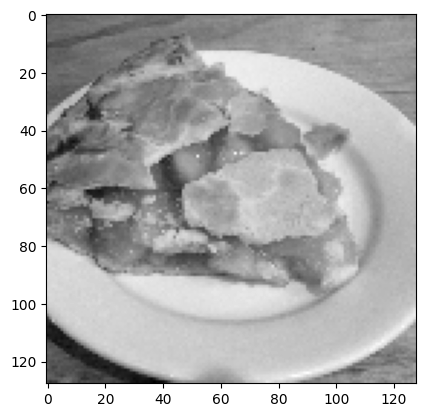

In [10]:
# print(name_labels[int(sample_batch[1][0])])
print(sample_batch[1][0])
print(model.predict(sample_batch[0][0:10, :, :, :]))
plt.imshow(sample_batch[0][0, :, :, :], cmap="gray")